In [3]:
import networkx as nx
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Functions to generate all connected graphs with N nodes
https://matplotlib.org/matplotblog/posts/draw-all-graphs-of-n-nodes/

In [4]:
def make_graphs(n=2, i=None, j=None):
    """Make a graph recursively, by either including, or skipping each edge.

    Edges are given in lexicographical order by construction."""
    out = []
    if i is None: # First call

        out  = [[(0,1)]+r for r in make_graphs(n=n, i=0, j=1)]
    elif j<n-1:
        out += [[(i,j+1)]+r for r in make_graphs(n=n, i=i, j=j+1)]
        out += [          r for r in make_graphs(n=n, i=i, j=j+1)]
    elif i<n-1:
        out = make_graphs(n=n, i=i+1, j=i+1)
    else:
        out = [[]]
    return out
def perm(n, s=None):
    """All permutations of n elements."""
    if s is None: return perm(n, tuple(range(n)))
    if not s: return [[]]
    return [[i]+p for i in s for p in perm(n, tuple([k for k in s if k!=i]))]
def permute(g, n):
    """Create a set of all possible isomorphic codes for a graph,

    as nice hashable tuples. All edges are i<j, and sorted lexicographically."""
    ps = perm(n)
    out = set([])
    for p in ps:
        out.add(tuple(sorted([(p[i],p[j]) if p[i]<p[j]
                              else (p[j],p[i]) for i,j in g])))
    return list(out)
def connected(g):
    """Check if the graph is fully connected, with Union-Find."""
    nodes = set([i for e in g for i in e])
    roots = {node: node for node in nodes}

    def _root(node, depth=0):
        if node==roots[node]: return (node, depth)
        else: return _root(roots[node], depth+1)

    for i,j in g:
        ri,di = _root(i)
        rj,dj = _root(j)
        if ri==rj: continue
        if di<=dj: roots[ri] = rj
        else:      roots[rj] = ri
    return len(set([_root(node)[0] for node in nodes]))==1
def filter(gs, target_nv):
    """Filter all improper graphs: those with not enough nodes,

    those not fully connected, and those isomorphic to previously considered."""
    mem = set({})
    gs2 = []
    for g in gs:
        nv = len(set([i for e in g for i in e]))
        if nv != target_nv:
            continue
        if not connected(g):
            continue
        if tuple(g) not in mem:
            gs2.append(g)
            mem |= set(permute(g, target_nv))
    return gs2

### Function to calculate expected distances as described by Camby and al. (2018)

In [10]:
def expected_distances(G):
    n = len(G.nodes())
    L = nx.laplacian_matrix(G).toarray()
    L_mod = [x+1 for x in L] #adding 1 to solve be able to inverse matrix L
    L_inv = np.linalg.inv(L_mod)
    distances = np.zeros((n,n))
    for s in G.nodes():
        for t in G.nodes():
            if s<t:
                S = np.zeros(n)
                S[s] = 1
                S[t] = -1
                V = np.matmul(S, L_inv) # vector of potentials
                expected_distance = 0
                for u,v in G.edges:
                    expected_distance += abs(V[u]-V[v])
                distances[s, t] = expected_distance
                distances[t, s] = expected_distance
    return distances


## Calculating distances for different graphs

In [8]:
def apply_color(distances, table):
    for i in range(0,NV-1):
        for j in range (0, NV-1):
            if j!=i and distances.iloc[i,j] == 0:
                table[(i+1,j)].set_facecolor("#FF0000")
def plot_graphs(gs, pos):
    n = len(gs)
    figsize=18
    fig = plt.figure(figsize=(figsize,figsize))
    k = int(np.sqrt(n))


    for i in range(n):
        plt.subplot(k+1,k+1,i+1)
        g = nx.Graph() # Generate a Networkx object

        for e in gs[i]:            
            g.add_edge(e[0],e[1])
        nx.draw(g, with_labels=True, pos=pos)

        #distances
        distances = pd.DataFrame(expected_distances(g)).round(2)
        table = plt.table(cellText=distances.values,
            colWidths = [0.1]*len(distances.columns.values),
            rowLabels=distances.index.values, colLabels=distances.columns.values,
            cellLoc = 'center', rowLoc = 'center')
        apply_color(distances, table)
        table.set_fontsize(14)
        table.scale(1.5, 1.5) 

### 3 nodes
Distances from node 0 to node 2

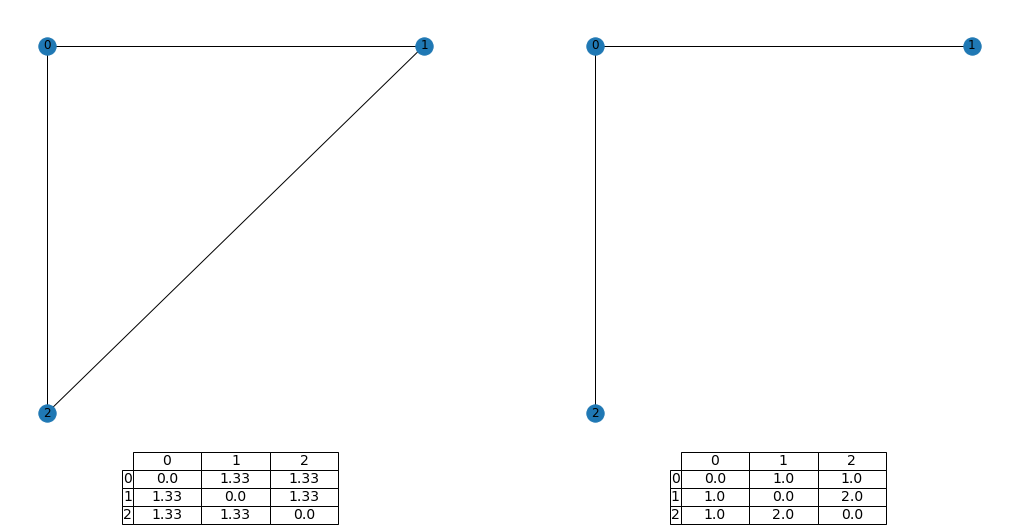

In [11]:
NV = 3
gs = make_graphs(NV)
gs = filter(gs, NV)
s = 0
t = 2
pos = { 0: (0, 40), 1: (40, 40), 2: (0, 0)}
plot_graphs(gs, pos)


#### 4 nodes
Distances from node 0 to node 3 (s = 0, t = 3)

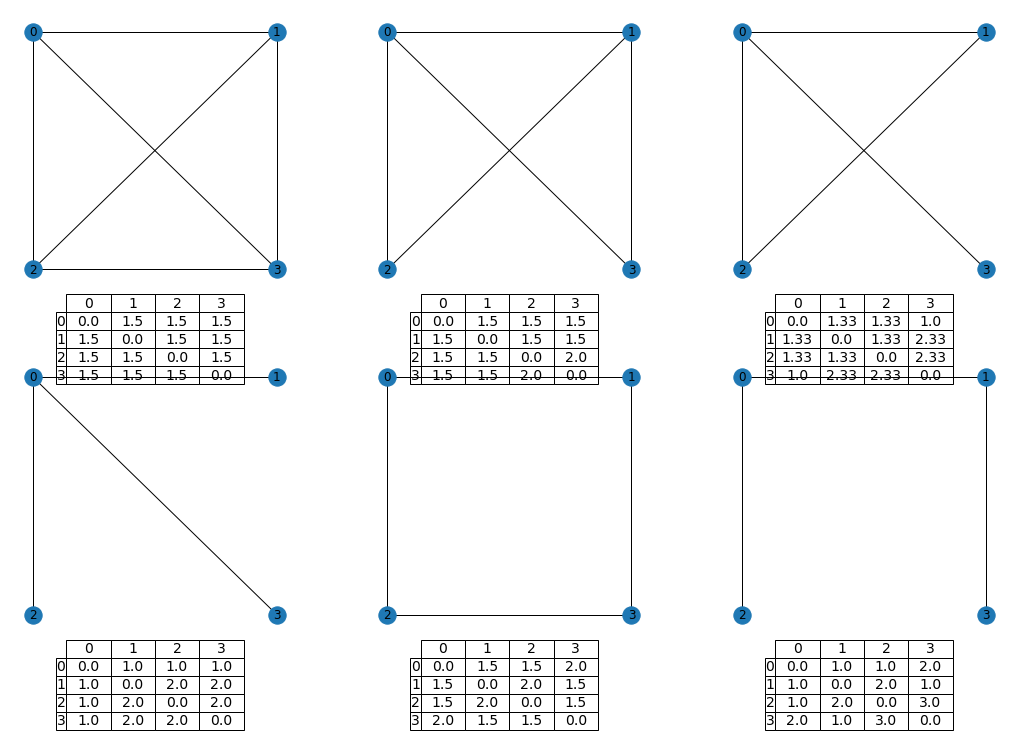

In [12]:
NV = 4
gs = make_graphs(NV)
gs = filter(gs, NV)
s = 0
t = 3
pos = { 0: (0, 40), 1: (40, 40), 2: (0, 0),3: (40, 0)}
plot_graphs(gs, pos)

### 5 nodes

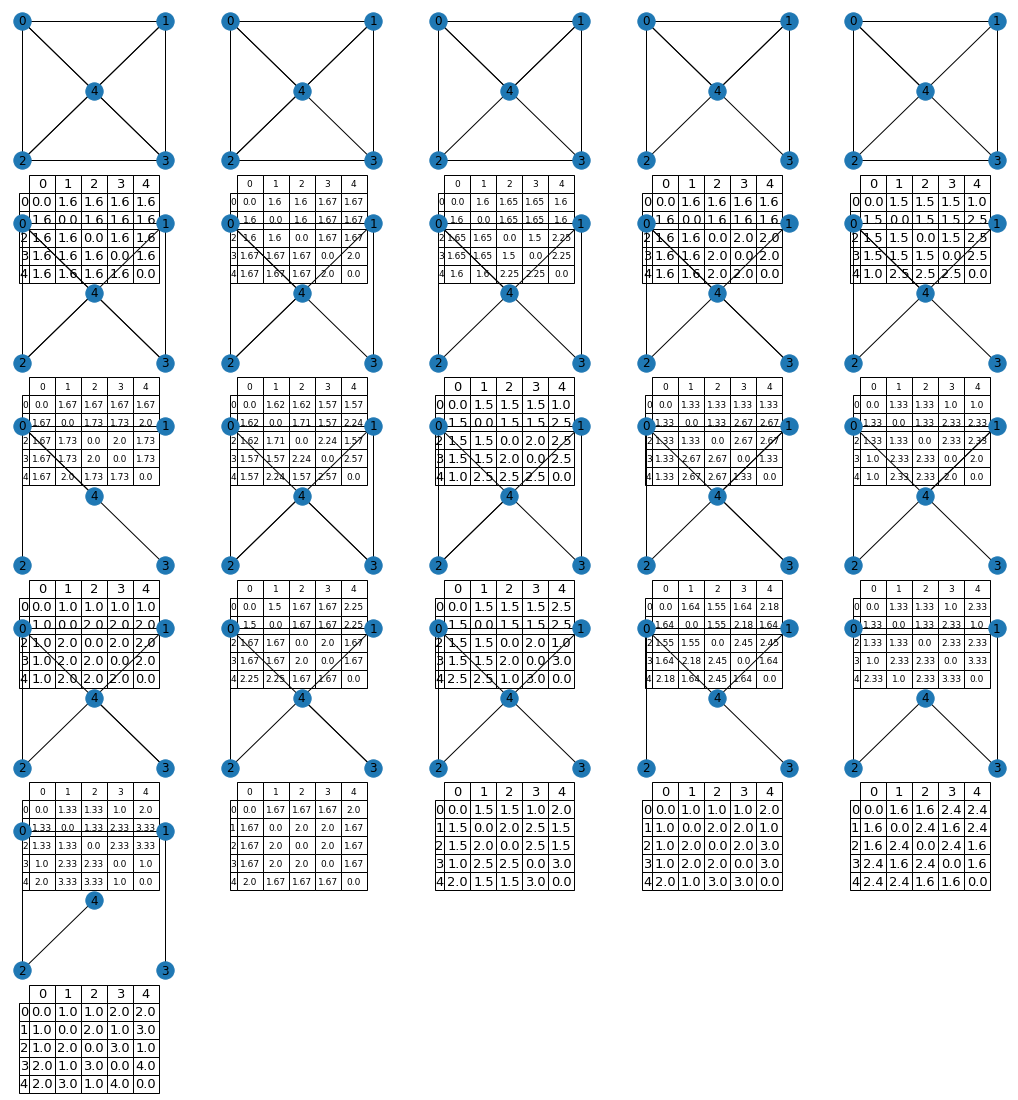

In [13]:
NV = 5
gs = make_graphs(NV)
gs = filter(gs, NV)
s = 0
t = 4
pos = { 0: (0, 40), 1: (40, 40), 2: (0, 0),3: (40, 0), 4:(20, 20)}
plot_graphs(gs, pos)